In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install huggingface_hub
!apt install libomp-dev
!pip install faiss-gpu

     |████████████████████████████████| 3.1 MB 8.6 MB/s 
     |████████████████████████████████| 56 kB 5.8 MB/s 
     |████████████████████████████████| 895 kB 72.9 MB/s 
     |████████████████████████████████| 596 kB 79.1 MB/s 
     |████████████████████████████████| 3.3 MB 69.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 8.5 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 239 kB of archives.
After this operat

In this work I will implement triplet loss approach for intent classification. Intent classification problem is very common in dialogue systems, because there can be a great amount of intet classes, each carrying its own system responce behaviour. 

Metric learning seems like a legit approach to this problem, because there can be numerous number of intent classes with imbalanced number of samples and we want to build such system, where we can fastly retrain our model with new samples. Also we would not want to overfit our model to a certain set of samples, instead we want to learn a metric which would be able to distinguish between different classes.


We can do it by learning a non linear function $F$ which will take an input vector $x \in R^m$, transform it in a new vector $x^* \in R^n$, where usually $n < m$. This function will transform vectors from $R^m$ in $R^n$ space in a such way that classes from one class will lie near each other and different classes will lie far away from each other. After this transformation we can use simple metric algorithms such as KNN in order to do classification.

We will be using triplet loss function with random sampling in order to learn desired fucntion capability.

This work is inspired by a Facebook paper - https://arxiv.org/abs/1503.03832


*As our base embeddings we will be using Hugging Face BERT-bert embeddings. The training will be conducted on GPU*

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from copy import deepcopy
from torch import optim
from torch.autograd import Variable
from IPython.display import clear_output
from tensorflow.keras.utils import Progbar
from sklearn.neighbors import KNeighborsClassifier
import transformers
import warnings
import faiss
import itertools
import json
import random
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
from sklearn import preprocessing

torch.manual_seed(42)
np.random.seed(42)


warnings.filterwarnings('ignore')

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")
DEVICE = torch.device(dev)  
FROZEN_BERT = BertModel.from_pretrained('bert-base-uncased').to(DEVICE)
%matplotlib inline

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The training, validation and test set I wiil be using OOS classification dataset. It contains 3 types of dataset - full, imbalanced and small datasets. Since I want to mimic the intent classification problem which occures a lot in dialogue systems - class imbalance, so I will be using imbalaced OOS dataset.
The paper for dataset - https://www.aclweb.org/anthology/D19-1131.pdf

In [ ]:
!git clone https://github.com/clinc/oos-eval.git

Cloning into 'oos-eval'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 69 (delta 16), reused 16 (delta 16), pack-reused 50
Unpacking objects: 100% (69/69), done.


In [ ]:
def to_df(input_array):
  numpy_array = np.array(input_array)
  intents = numpy_array[:, 0]
  targets = numpy_array[:, 1]
  df = pd.DataFrame()
  df['intents'] = intents
  df['targets'] = targets
  return df

data_full = json.load(open('/content/oos-eval/data/data_full.json', 'r'))

dataset_list = []
for key in data_full:
  df = to_df(data_full[key])
  dataset_list.append(df)

total_df = pd.concat(dataset_list, axis=0, sort=False).reset_index(drop=True)
print('Total size: ', total_df.shape)
total_df.head()

Total size:  (23700, 2)


,intents,targets
0,set a warning for when my bank account starts ...,oos
1,a show on broadway,oos
2,who has the best record in the nfl,oos
3,how do i find the area of a circle,oos
4,how many onions do i have on hand,oos


We will split files in following fashion - 60% classes to train, 20% to dev, 20% to test.

In [ ]:
classes_list = list(set(total_df.targets.tolist()))
random.shuffle(classes_list)

TRAIN_SPLIT = 0.6
train_classes, eval_classes = classes_list[:int(len(classes_list)*TRAIN_SPLIT)], classes_list[int(len(classes_list)*TRAIN_SPLIT):]
TEST_SPLIT = 0.5
val_classes, test_classes = eval_classes[:int(len(eval_classes)*TEST_SPLIT)], eval_classes[int(len(eval_classes)*TEST_SPLIT):]

train_df = total_df[total_df.targets.isin(train_classes)]
val_df = total_df[total_df.targets.isin(val_classes)]
test_df = total_df[total_df.targets.isin(test_classes)]
X_test_seen, X_test_unseen, y_test_seen, y_test_unseen = train_test_split(test_df['intents'].to_list(), test_df['targets'].to_list(), 
                                                                          test_size=0.4, random_state=42)
seen_test_df = pd.DataFrame({'intents': X_test_seen,
                             'targets': y_test_seen})
unseen_test_df = pd.DataFrame({'intents': X_test_unseen,
                             'targets': y_test_unseen})

#classes from train & val does not intersect
assert len(set(train_df.targets.tolist()).intersection(val_df.targets.tolist())) == 0
#classes from train & test does not intersect
assert len(set(train_df.targets.tolist()).intersection(test_df.targets.tolist())) == 0
#classes from val & test does not intersect
assert len(set(val_df.targets.tolist()).intersection(test_df.targets.tolist())) == 0
#classes from seen test & unseen test intersect fully
assert len(set(seen_test_df.targets.tolist()).intersection(unseen_test_df.targets.tolist())) == len(test_classes)

print(f'Train shape: {train_df.shape}, classes: {len(train_df.targets.value_counts())}')
print(f'Val shape: {val_df.shape}, classes: {len(val_df.targets.value_counts())}')
print(f'Seen test shape: {seen_test_df.shape}, classes: {len(seen_test_df.targets.value_counts())}')
print(f'Unseen test shape: {unseen_test_df.shape}, classes: {len(unseen_test_df.targets.value_counts())}')

Train shape: (13500, 2), classes: 90
Val shape: (4500, 2), classes: 30
Seen test shape: (3420, 2), classes: 31
Unseen test shape: (2280, 2), classes: 31


Here I will prepare data for input into BERT-base model. We will tokenize, pad it and mask padded symbols in order not to confuse BERT.

In [ ]:
MAX_LEN= 512

def create_tranformer_input(sample_list):
  tokens_ids_list, attention_masks_list = [], []
  for sample in sample_list:
    tokenized_sample = TOKENIZER.tokenize(sample)
    tokenized_sample = ['[CLS]'] + tokenized_sample + ['[SEP]']

    if len(tokenized_sample) < MAX_LEN:
      tokenized_sample = tokenized_sample + ['[PAD]'] * (MAX_LEN - len(tokenized_sample))
    else:
      tokenized_sample = tokenized_sample[:MAX_LEN - 1] + ['[PAD]']
    
    tokens_ids = TOKENIZER.convert_tokens_to_ids(tokenized_sample)
    tokens_ids = torch.Tensor(tokens_ids).long().resize_((1,MAX_LEN)).to(DEVICE)

    attention_mask = (tokens_ids != 0).long().resize_((1,MAX_LEN)).to(DEVICE)

    tokens_ids_list.append(tokens_ids)
    attention_masks_list.append(attention_mask)
  tokens_ids = torch.cat(tokens_ids_list, axis=0)
  attention_masks = torch.cat(attention_masks_list, axis=0)
  
  return tokens_ids, attention_masks

def encode_data(text_samples, bert_encoder, batch_size=256, verbose=True):
    encoded_data = []
    bert_encoder.eval()
    tokens_ids, attention_mask = create_tranformer_input(text_samples)
    with torch.no_grad():
        if verbose:
          bar = Progbar(int(len(tokens_ids)/batch_size))
        for batch_number in range(0, tokens_ids.shape[0], batch_size):
          samples_vector = tokens_ids[batch_number:batch_number + batch_size]
          attention_vector = attention_mask[batch_number:batch_number + batch_size]
          outputs = bert_encoder.forward(samples_vector, attention_mask=attention_vector)
          pooler_output = outputs['pooler_output']
          encoded_data.append(pooler_output)
          if verbose:
            bar.add(1)
    encoded_data = torch.cat(encoded_data, dim=0)
    return encoded_data

encode_data(['hi, hi'], FROZEN_BERT, 1, False)

tensor([[-7.9588e-01, -2.4578e-01, -8.3082e-01,  6.7608e-01,  5.5406e-01,
         -5.7891e-02,  7.3652e-01,  1.6235e-01, -4.4965e-01, -9.9988e-01,
         -2.7525e-01,  8.6535e-01,  9.7135e-01,  4.4013e-01,  9.0157e-01,
         -5.3342e-01, -3.1664e-01, -4.1415e-01,  3.1627e-01, -1.2740e-01,
          4.9049e-01,  9.9991e-01,  1.6662e-01,  9.6635e-02,  3.7986e-01,
          9.7159e-01, -7.6144e-01,  9.0673e-01,  9.4718e-01,  5.5351e-01,
         -4.7194e-01, -3.4664e-02, -9.8909e-01, -1.1515e-01, -9.4033e-01,
         -9.8549e-01,  1.8738e-01, -6.7372e-01,  5.4439e-03,  2.2855e-01,
         -8.8937e-01,  1.0872e-01,  9.9984e-01,  9.9845e-02,  3.5894e-01,
         -1.4926e-01, -9.9999e-01,  1.3791e-01, -8.0076e-01,  7.4017e-01,
          7.9485e-01,  6.7085e-01,  2.9789e-02,  3.7836e-01,  2.8681e-01,
         -1.0542e-01, -1.7777e-01,  7.7549e-02, -1.1649e-01, -4.7824e-01,
         -4.7618e-01,  2.6904e-01, -8.4538e-01, -8.8193e-01,  8.0556e-01,
          7.1235e-01, -1.4072e-01, -1.

In [ ]:
train_embeddings = encode_data(train_df['intents'].to_list(), FROZEN_BERT)
print('Train shape: ', train_embeddings.shape)

val_embeddings = encode_data(val_df['intents'].to_list(), FROZEN_BERT)
print('Val shape: ', val_embeddings.shape)

seen_test_embeddings = encode_data(seen_test_df['intents'].to_list(), FROZEN_BERT)
print('Train shape: ',seen_test_embeddings.shape)

unseen_test_embeddings = encode_data(unseen_test_df['intents'].to_list(), FROZEN_BERT)
print('Train shape: ',unseen_test_embeddings.shape)

53/52 [==============================] - 219s 4s/step
Train shape:  torch.Size([13500, 768])
18/17 [===============================] - 66s 4s/step
Val shape:  torch.Size([4500, 768])
14/13 [================================] - 49s 4s/step
Train shape:  torch.Size([3420, 768])
9/8 [=================================] - 27s 3s/step
Train shape:  torch.Size([2280, 768])


In [ ]:
train_embeddings.shape

torch.Size([13500, 768])

Lets look at the embeddigns that we have in TSNE.

In [ ]:
def get_indexes_of_samples(target_array):
    labels_dict = {}
    distinct_labels = set(target_array)
    for label in distinct_labels:
        labels_dict[label] = [i for i,val in enumerate(target_array) if val==label]
    return labels_dict

CPU times: user 1min 4s, sys: 140 ms, total: 1min 4s
Wall time: 29.2 s


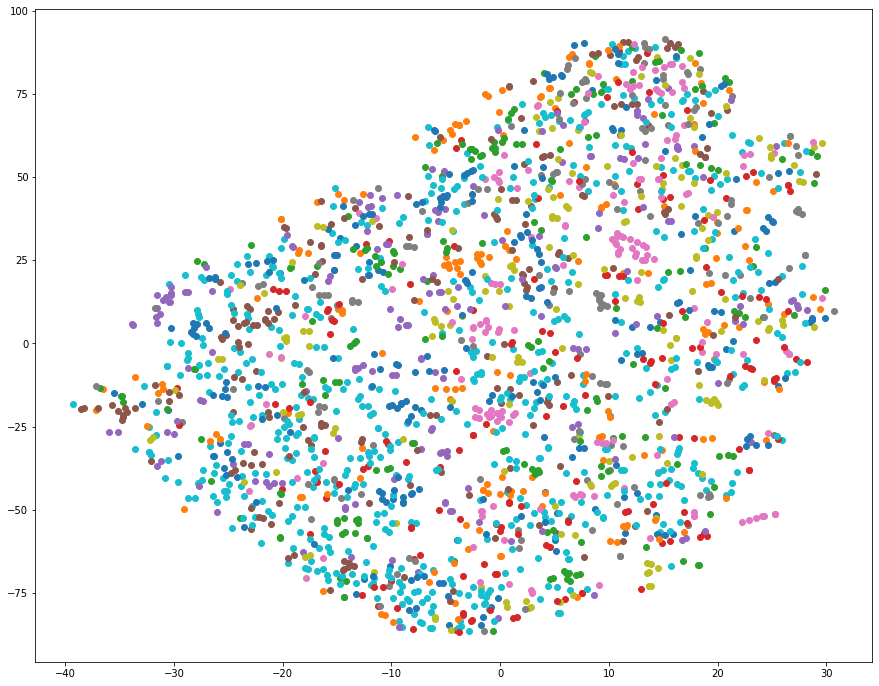

In [ ]:
%%time
from sklearn.manifold import TSNE
plt.figure(figsize=(15,12))


tsne = TSNE()
tsne_original_val_emb = tsne.fit_transform(unseen_test_embeddings.cpu())
val_classes_indexes = get_indexes_of_samples(unseen_test_df['targets'].values)

for key, val in val_classes_indexes.items():
    plt.scatter(x=tsne_original_val_emb[val,0],y=tsne_original_val_emb[val,1],label=key)

### Baseline model



In [ ]:
storage_embeddings = np.concatenate([train_embeddings.cpu().detach().numpy(), 
                                val_embeddings.cpu().detach().numpy(),
                                seen_test_embeddings.cpu().detach().numpy()], axis=0)
classes_array = train_df['targets'].to_list() + val_df['targets'].to_list() + seen_test_df['targets'].to_list()
storage_embeddings.shape, len(classes_array)

((21420, 768), 21420)

In [ ]:
train_df.targets.value_counts()

who_made_you                 150
spelling                     150
pto_request_status           150
find_phone                   150
replacement_card_duration    150
                            ... 
greeting                     150
timezone                     150
pay_bill                     150
damaged_card                 150
report_fraud                 150
Name: targets, Length: 90, dtype: int64

In [ ]:
class KnnIndex:
  def __init__(self, embeddings, classes_array, encoder):
    self.bert_encoder = encoder

    self.to_retrieve = 1

    self.index = faiss.IndexFlatL2(embeddings.shape[1])
    self.index.train(embeddings)
    self.index.add(embeddings)

    self.classes_array = classes_array


  def search_index(self, text_sample):
    vectorized_query = encode_data([text_sample], self.bert_encoder, 1, False).cpu().detach().numpy()
    dense_search_results = self.index.search(vectorized_query, self.to_retrieve)
    dense_index = dense_search_results[1][0][0]
    closest_class = self.classes_array[dense_index]
    return closest_class

knn_index = KnnIndex(storage_embeddings, classes_array, FROZEN_BERT)
knn_index.search_index('how old are you')

'how_old_are_you'

In [ ]:
#lets evaluate
preds = []
bar = Progbar(len(unseen_test_df))
test_intents = set(unseen_test_df['targets'].to_list())
for sample in unseen_test_df['intents'].to_list():
  pred_class = knn_index.search_index(sample)
  if pred_class in test_intents:
    preds.append(pred_class)
  else:
    preds.append('misclassified')
  bar.add(1)

2280/2280 [==============================] - 103s 45ms/step


In [ ]:
print(classification_report(preds, unseen_test_df['targets'].tolist()))

                        precision    recall  f1-score   support

                 alarm       0.42      0.84      0.56        25
                cancel       0.20      0.55      0.29        22
    cancel_reservation       0.33      0.82      0.47        22
         card_declined       0.34      0.80      0.48        25
        change_ai_name       0.44      0.82      0.57        28
          change_speed       0.25      0.73      0.37        22
            directions       0.40      0.79      0.53        29
      do_you_have_pets       0.47      0.90      0.62        31
         flight_status       0.40      0.86      0.54        29
        freeze_account       0.34      0.69      0.46        29
              fun_fact       0.37      0.76      0.50        37
      ingredients_list       0.39      0.74      0.51        35
      insurance_change       0.33      0.61      0.43        36
       meal_suggestion       0.37      0.82      0.51        28
measurement_conversion       0.51      

### Metric learning approach

In order to sample easily, I will form dict of classes with samples indexes for each class.

In [ ]:
train_target_indexes_dict = get_indexes_of_samples(train_df['targets'].to_list())
val_target_indexes_dict = get_indexes_of_samples(val_df['targets'].to_list())

print('Target types: ', train_target_indexes_dict.keys())
print('Number of classes: ', len(train_target_indexes_dict.keys()))

Target types:  dict_keys(['tire_pressure', 'cook_time', 'thank_you', 'report_fraud', 'confirm_reservation', 'income', 'shopping_list_update', 'insurance', 'account_blocked', 'recipe', 'make_call', 'todo_list', 'vaccines', 'maybe', 'travel_alert', 'goodbye', 'last_maintenance', 'gas', 'pto_request', 'book_flight', 'where_are_you_from', 'food_last', 'bill_balance', 'uber', 'direct_deposit', 'spelling', 'credit_score', 'calculator', 'current_location', 'international_visa', 'application_status', 'ingredient_substitution', 'pto_request_status', 'order', 'improve_credit_score', 'travel_notification', 'find_phone', 'book_hotel', 'replacement_card_duration', 'play_music', 'what_is_your_name', 'jump_start', 'flip_coin', 'meeting_schedule', 'who_do_you_work_for', 'how_busy', 'calories', 'tell_joke', 'schedule_maintenance', 'oil_change_how', 'gas_type', 'tire_change', 'credit_limit_change', 'roll_dice', 'exchange_rate', 'routing', 'meaning_of_life', 'next_holiday', 'international_fees', 'definit

In [ ]:
train_token_ids_array, train_attention_mask_array = create_tranformer_input(train_df['intents'].to_list())
val_token_ids_array, val_attention_mask_array = create_tranformer_input(val_df['intents'].to_list())
train_token_ids_array.shape, val_token_ids_array.shape

(torch.Size([13500, 512]), torch.Size([4500, 512]))

The main key point in metric learning is sampling strategy. Here I will implement random sampling strategy. 

Random sampling strategy simply gets random sample from other classes excluding the anchor class.

In [ ]:
class TripletGenerator:
  def __init__(self,class2idx_dict, attention_storage, token_ids_storage, batch_size):
    self.class2idx_dict = class2idx_dict
    self.attention_storage = attention_storage
    self.token_ids_storage = token_ids_storage

    self.classes = list(self.class2idx_dict.keys())
    self.batch_size = batch_size

  def __call__(self):
    anchor_list, positive_list, negative_list = [], [], []
    for _ in range(self.batch_size):
      sample_dict = self.get_triplet()
      anchor_list.append(sample_dict['anchor'])
      positive_list.append(sample_dict['positive'])
      negative_list.append(sample_dict['negative'])
    anchor_array = np.array(anchor_list)
    positive_array = np.array(positive_list)
    negative_array = np.array(negative_list)

    return {"anchor": [torch.vstack(list(anchor_array[:, 0])), torch.vstack(list(anchor_array[:, 1]))],
            "positive": [torch.vstack(list(positive_array[:, 0])), torch.vstack(list(positive_array[:, 1]))],
            "negative": [torch.vstack(list(negative_array[:, 0])), torch.vstack(list(negative_array[:, 1]))]
            }
  
  def get_triplet(self):
    anchor_class = random.choice(self.classes)
    anchor_sample_idx = random.choice(self.class2idx_dict[anchor_class])
    positive_sample_idx = TripletGenerator.random_choose(self.class2idx_dict[anchor_class], anchor_sample_idx)
    negative_class = TripletGenerator.random_choose(self.classes, anchor_class)
    negative_sample_idx = random.choice(self.class2idx_dict[negative_class])

    anchor_token_ids, anchor_attention_mask = self.attention_storage[anchor_sample_idx], self.token_ids_storage[anchor_sample_idx]
    positive_token_ids, positive_attention_mask = self.attention_storage[positive_sample_idx], self.token_ids_storage[positive_sample_idx]
    negative_token_ids, negative_attention_mask = self.attention_storage[negative_sample_idx], self.token_ids_storage[negative_sample_idx]

    return {
        "anchor": [anchor_token_ids, anchor_attention_mask],
        "positive": [positive_token_ids, positive_attention_mask],
        "negative": [negative_token_ids, negative_attention_mask]
    }

  @staticmethod
  def random_choose(sequence, exclude_sample=None, retires=5):
        for _ in range(retires):
            choice = random.choice(sequence)
            if choice != exclude_sample:
                break
        return choice


train_triplet_generator = TripletGenerator(train_target_indexes_dict, train_token_ids_array, train_attention_mask_array, 2)
example_batch = train_triplet_generator()
example_batch['anchor'][0].shape, example_batch['negative'][0].shape

(torch.Size([2, 512]), torch.Size([2, 512]))

In [ ]:
class MetricBERT(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = deepcopy(bert_model)

    def disable_bert_training(self):
      for layer in self.bert.encoder.layer:
        for param in layer.parameters():
          param.requires_grad = False

    def enable_some_bert_layers_training(self, layers2freeze):
      layers4freeze = [*[self.bert.encoder.layer[:layers2freeze]] + [self.bert.embeddings]]
      layers2train = [*self.bert.encoder.layer[layers2freeze - len(self.bert.encoder.layer):]]
      for layer in layers4freeze:
        for param in layer.parameters():
          param.requires_grad = False

      for layer in layers2train:
        for param in layer.parameters():
          param.requires_grad = True
      
    def forward(self, anchor_data, pos_data, neg_data):
        SEQUENCE_IDX = 0
        ATTENTION_MASK_IDX = 1

        anchor_bert_ouput = self.bert(anchor_data[SEQUENCE_IDX], 
                                      anchor_data[ATTENTION_MASK_IDX])
        anchor_cls_repr = anchor_bert_ouput['pooler_output']

        neg_bert_output = self.bert(neg_data[SEQUENCE_IDX],
                                    neg_data[ATTENTION_MASK_IDX])
        neg_cls_repr = neg_bert_output['pooler_output']

        pos_bert_output = self.bert(pos_data[SEQUENCE_IDX], 
                                    pos_data[ATTENTION_MASK_IDX])
        pos_cls_repr = pos_bert_output['pooler_output']
        
        return anchor_cls_repr, pos_cls_repr, neg_cls_repr

In [ ]:
metric_bert = MetricBERT(FROZEN_BERT)

In [ ]:
for i in list(metric_bert.named_parameters()):
  if i[1].requires_grad == True:
    print(i[0], i[1].requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


In this work I am using custom loss function - triplet loss function. As a distance metric I will be using l2 distance.

In [ ]:
def l2_distance(a, b):
    distance_matrix = torch.cdist(a, b, p=2)
    diag_sum = torch.sum(torch.diagonal(distance_matrix))
    return diag_sum

def compute_loss(anchor_sample, pos_sample, neg_sample, distance_metric, delta = 1):
    pos_sim = distance_metric(anchor_sample, pos_sample)
    neg_sim = distance_metric(anchor_sample, neg_sample)
    loss = torch.max(torch.Tensor([0]).to(DEVICE), delta - neg_sim + pos_sim)
    return loss

a = torch.Tensor([[1,1], [3,4]]).to(DEVICE)
pos = torch.Tensor([[2,3], [5,6]]).to(DEVICE)
neg = torch.Tensor([[1,1], [1,2]]).to(DEVICE)
print('Triplet loss result:', compute_loss(a, pos, neg, l2_distance))

Triplet loss result: tensor([3.2361], device='cuda:0')


Here is presented the training of the dssm model for metric learning. As a validation metric I use recall - check if anchor to positive distance is less than anchor to negative for a given triplet.

I will be using l2 distance, because in current setting cos proved itself to be not so good.



In [ ]:
torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 6.3 GB
Cached:    13.0 GB


In [ ]:
import sklearn

def compute_silhouette_score(number_of_classes, target_indexes_dict, token_ids_array, attention_mask_array, encoder):
  targets = random.sample(list(target_indexes_dict.keys()), number_of_classes)
  token_ids, attention_mask  = [], []
  embeddings_list, targets_list=[], []
  bar = Progbar(len(targets))
  for target in targets:
    samples_idx = target_indexes_dict[target]
    random.shuffle(samples_idx)
    samples_idx = samples_idx[:int(len(samples_idx)*0.3)]
    token_ids, attention_masks = token_ids_array[samples_idx], token_ids_array[samples_idx]
    with torch.no_grad():
      embeddings = encoder.forward(token_ids, attention_masks)['pooler_output'].cpu().detach().numpy()
    embeddings_list.append(embeddings)
    targets_list += [target]*len(samples_idx)
    bar.add(1)
  embeddings_numpy = np.concatenate(embeddings_list, axis=0)
  silhouette_score = sklearn.metrics.silhouette_score(embeddings_numpy, targets_list)
  return silhouette_score

compute_silhouette_score(10, train_target_indexes_dict, train_token_ids_array, train_attention_mask_array, FROZEN_BERT)

10/10 [==============================] - 8s 776ms/step


0.0011948469

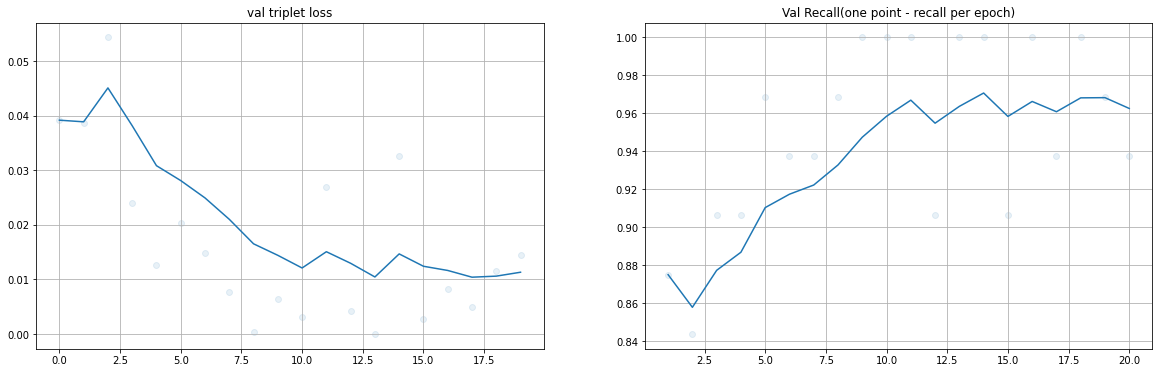

In [ ]:
DISTANCE_METRIC = l2_distance
DELTA=0.1
LAYERS2FREEZE=9

# model hyperparams
lr = 2e-5
DATASET_PASSES = 20
EPOCH_STEPS = 256
VAL_STEPS = 32
BATCH_SIZE = 8

train_generator = TripletGenerator(train_target_indexes_dict, train_token_ids_array, train_attention_mask_array, 2)

val_generator = TripletGenerator(val_target_indexes_dict, val_token_ids_array, val_attention_mask_array, 2)

metric_bert = MetricBERT(FROZEN_BERT)

optimizer = optim.Adam(metric_bert.parameters(), lr=lr)

train_loss_history_array, train_silouhette_history_array = [], []
val_loss_history_array, val_recall_history_array = [], []

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

try:
    for epoch in range(DATASET_PASSES):
        #training

        epoch_train_loss = 0
        metric_bert.enable_some_bert_layers_training(layers2freeze=LAYERS2FREEZE)

        bar=Progbar(EPOCH_STEPS)
        for _ in range(EPOCH_STEPS):
            batch_sample = train_generator()
            optimizer.zero_grad()
            train_anchor_proj, train_pos_proj, train_neg_proj = metric_bert.forward(batch_sample['anchor'], 
                                                                                    batch_sample['positive'], 
                                                                                    batch_sample['negative'])
            batch_train_loss = compute_loss(anchor_sample=train_anchor_proj, 
                                             pos_sample=train_pos_proj, 
                                             neg_sample=train_neg_proj,
                                             distance_metric=DISTANCE_METRIC)
            batch_train_loss.backward()
            optimizer.step()
            epoch_train_loss += batch_train_loss.item()
            bar.add(1)
        
        #Average Loss per sample
        train_loss_history_array.append(epoch_train_loss / (EPOCH_STEPS * BATCH_SIZE))
        epoch_train_silouhette = compute_silhouette_score(10, train_target_indexes_dict, train_token_ids_array, train_attention_mask_array, metric_bert.bert)
        train_silouhette_history_array.append(epoch_train_silouhette)

        clear_output(True)
        plt.figure(figsize=[28, 10])

        #loss plot
        plt.subplot(2, 2, 1), plt.title('train triplet loss'), plt.grid()
        plt.scatter(np.arange(len(train_loss_history_array)), train_loss_history_array, alpha=0.1)
        plt.plot(ewma(train_loss_history_array, span=10))

        #silouhette plot
        plt.subplot(2, 2, 2), plt.title('train silouhette metric'), plt.grid()
        plt.scatter(np.arange(len(train_silouhette_history_array)), train_silouhette_history_array, alpha=0.1)
        plt.plot(ewma(train_silouhette_history_array, span=10))

        #check gradient flow
        layers_list, average_grads_list = [], []
        for layer_name, params in metric_bert.named_parameters():
          if (params.requires_grad) and ("bias" not in layer_name):
            layers_list.append(layer_name)
            average_grads_list.append(params.grad.abs().mean().item())

        plt.subplot(2, 2, 3), plt.title('training average grads per sample pass'), plt.grid()
        plt.scatter(layers_list, average_grads_list, alpha=0.1)
        plt.xticks(range(0,len(average_grads_list), 1), layers_list, rotation="vertical")
        plt.plot(ewma(average_grads_list, span=10))
        plt.show()

        print('Train silouhette value: ', train_silouhette_history_array[-1])
          

        # validation

        # disable bert training for all layers
        metric_bert.disable_bert_training()
        metric_bert.eval()

        epoch_val_loss = 0
        epoch_val_recall = 0
        bar = Progbar(VAL_STEPS)
        for _ in range(VAL_STEPS):
            batch_sample = val_generator()
            with torch.no_grad():
                val_anchor_proj, val_pos_proj, val_neg_proj = metric_bert.forward(batch_sample['anchor'], 
                                                                                  batch_sample['positive'], 
                                                                                  batch_sample['negative'])
                batch_val_loss = compute_loss(anchor_sample=val_anchor_proj, 
                                              pos_sample=val_pos_proj, 
                                              neg_sample=val_neg_proj,
                                              distance_metric=DISTANCE_METRIC)
                epoch_val_loss += batch_val_loss.item()
                bar.add(1)


            #calculate recall - our anchor is closer to pos than to neg
            anchor2pos_distance = DISTANCE_METRIC(val_anchor_proj, val_pos_proj)
            anchor2neg_distance = DISTANCE_METRIC(val_anchor_proj, val_neg_proj)
            
            if anchor2neg_distance > anchor2pos_distance + DELTA:
                epoch_val_recall += 1
                
        #Average loss per sample
        val_loss_history_array.append(epoch_val_loss / (VAL_STEPS * BATCH_SIZE))
        #Recall per one epoch pass
        val_recall_history_array.append(epoch_val_recall / VAL_STEPS)

        clear_output(True)
        plt.figure(figsize=[20, 6])
        plt.subplot(1, 2, 1), plt.title('val triplet loss'), plt.grid()
        plt.scatter(np.arange(len(val_loss_history_array)), val_loss_history_array, alpha=0.1)
        plt.plot(ewma(val_loss_history_array, span=10))

        # how many samples did we correctly arranged in space currently
        plt.subplot(1, 2, 2), plt.title('Val Recall(one point - recall per epoch)'), plt.grid()
        dev_time = np.arange(1, len(val_recall_history_array) + 1)
        plt.scatter(dev_time, val_recall_history_array, alpha=0.1)
        plt.plot(dev_time, ewma(val_recall_history_array, span=10))
        plt.show()      
            
except KeyboardInterrupt:
    pass

In [ ]:
encode_data(['hi'], FROZEN_BERT, 1)[0][0]

1/1 [==============================] - 0s 9ms/step


tensor(-0.7862, device='cuda:0')

In [ ]:
encode_data(['hi'], metric_bert.bert, 1)[0][0]

1/1 [==============================] - 0s 9ms/step


tensor(-0.7995, device='cuda:0')

In [ ]:
finetuned_bert_to_save = metric_bert.bert.module if hasattr(metric_bert.bert, 'module') else metric_bert.bert  
finetuned_bert_to_save.save_pretrained('training_result/oos_finetuned_bert')

After we have seen that our loss moved to plateau, lets learn KNN classifier on top of the new learned embeddings.

In [ ]:
new_train_embeddings = encode_data(train_df['intents'].to_list(), metric_bert.bert, 64)
print('Train shape: ', new_train_embeddings.shape)

new_val_embeddings = encode_data(val_df['intents'].to_list(), metric_bert.bert, 64)
print('Val shape: ', new_val_embeddings.shape)

new_seen_test_embeddings = encode_data(seen_test_df['intents'].to_list(), metric_bert.bert, 64)
print('Seen test shape: ',new_seen_test_embeddings.shape)

new_unseen_test_embeddings = encode_data(unseen_test_df['intents'].to_list(), metric_bert.bert, 64)
print('Unseen test shape: ',new_unseen_test_embeddings.shape)

211/210 [==============================] - 227s 1s/step
Train shape:  torch.Size([13500, 768])
71/70 [==============================] - 74s 1s/step
Val shape:  torch.Size([4500, 768])
54/53 [==============================] - 56s 1s/step
Seen test shape:  torch.Size([3420, 768])
36/35 [==============================] - 36s 1s/step
Unseen test shape:  torch.Size([2280, 768])


In [ ]:
new_storage_embeddings = np.concatenate([new_train_embeddings.cpu().detach().numpy(), 
                                new_val_embeddings.cpu().detach().numpy(),
                                new_seen_test_embeddings.cpu().detach().numpy()], axis=0)
classes_array = train_df['targets'].to_list() + val_df['targets'].to_list() + seen_test_df['targets'].to_list()
new_storage_embeddings.shape, len(classes_array)

((21420, 768), 21420)

In [ ]:
knn_index = KnnIndex(new_storage_embeddings, classes_array, metric_bert.bert)
knn_index.search_index('how old are you')

'how_old_are_you'

In [ ]:
#lets evaluate
preds = []
bar = Progbar(len(unseen_test_df))
test_intents = set(unseen_test_df['targets'].to_list())
for sample in unseen_test_df['intents'].to_list():
  pred_class = knn_index.search_index(sample)
  if pred_class in test_intents:
    preds.append(pred_class)
  else:
    preds.append('misclassified')
  bar.add(1)

print(classification_report(preds, unseen_test_df['targets'].tolist()))

2280/2280 [==============================] - 103s 45ms/step
                        precision    recall  f1-score   support

                 alarm       0.94      0.90      0.92        52
                cancel       0.52      0.79      0.63        39
    cancel_reservation       0.56      0.88      0.68        34
         card_declined       0.72      0.89      0.80        47
        change_ai_name       0.67      0.92      0.78        38
          change_speed       0.69      0.94      0.79        47
            directions       0.51      0.85      0.64        34
      do_you_have_pets       1.00      0.98      0.99        60
         flight_status       0.84      0.98      0.91        54
        freeze_account       0.69      0.95      0.80        42
              fun_fact       0.57      0.70      0.63        61
      ingredients_list       0.54      0.90      0.67        40
      insurance_change       0.77      0.94      0.85        54
       meal_suggestion       0.68      0.93

In [ ]:
old_encoded_test_data = encode_data(['Hi, my name is Oleg'], FROZEN_BERT, 1)
new_encoded_test_data = encode_data(['Hi, my name is Oleg'], metric_bert.bert, 1)

print('frozen bert: ', old_encoded_test_data[0][:5])
print('finetuned bert: ', new_encoded_test_data[0][:5])

1/1 [==============================] - 0s 9ms/step
frozen bert:  tensor([-0.9013, -0.6201, -0.9820,  0.8580,  0.8900], device='cuda:0')
finetuned bert:  tensor([-0.9553, -0.3056, -0.9712,  0.8568,  0.4813], device='cuda:0')


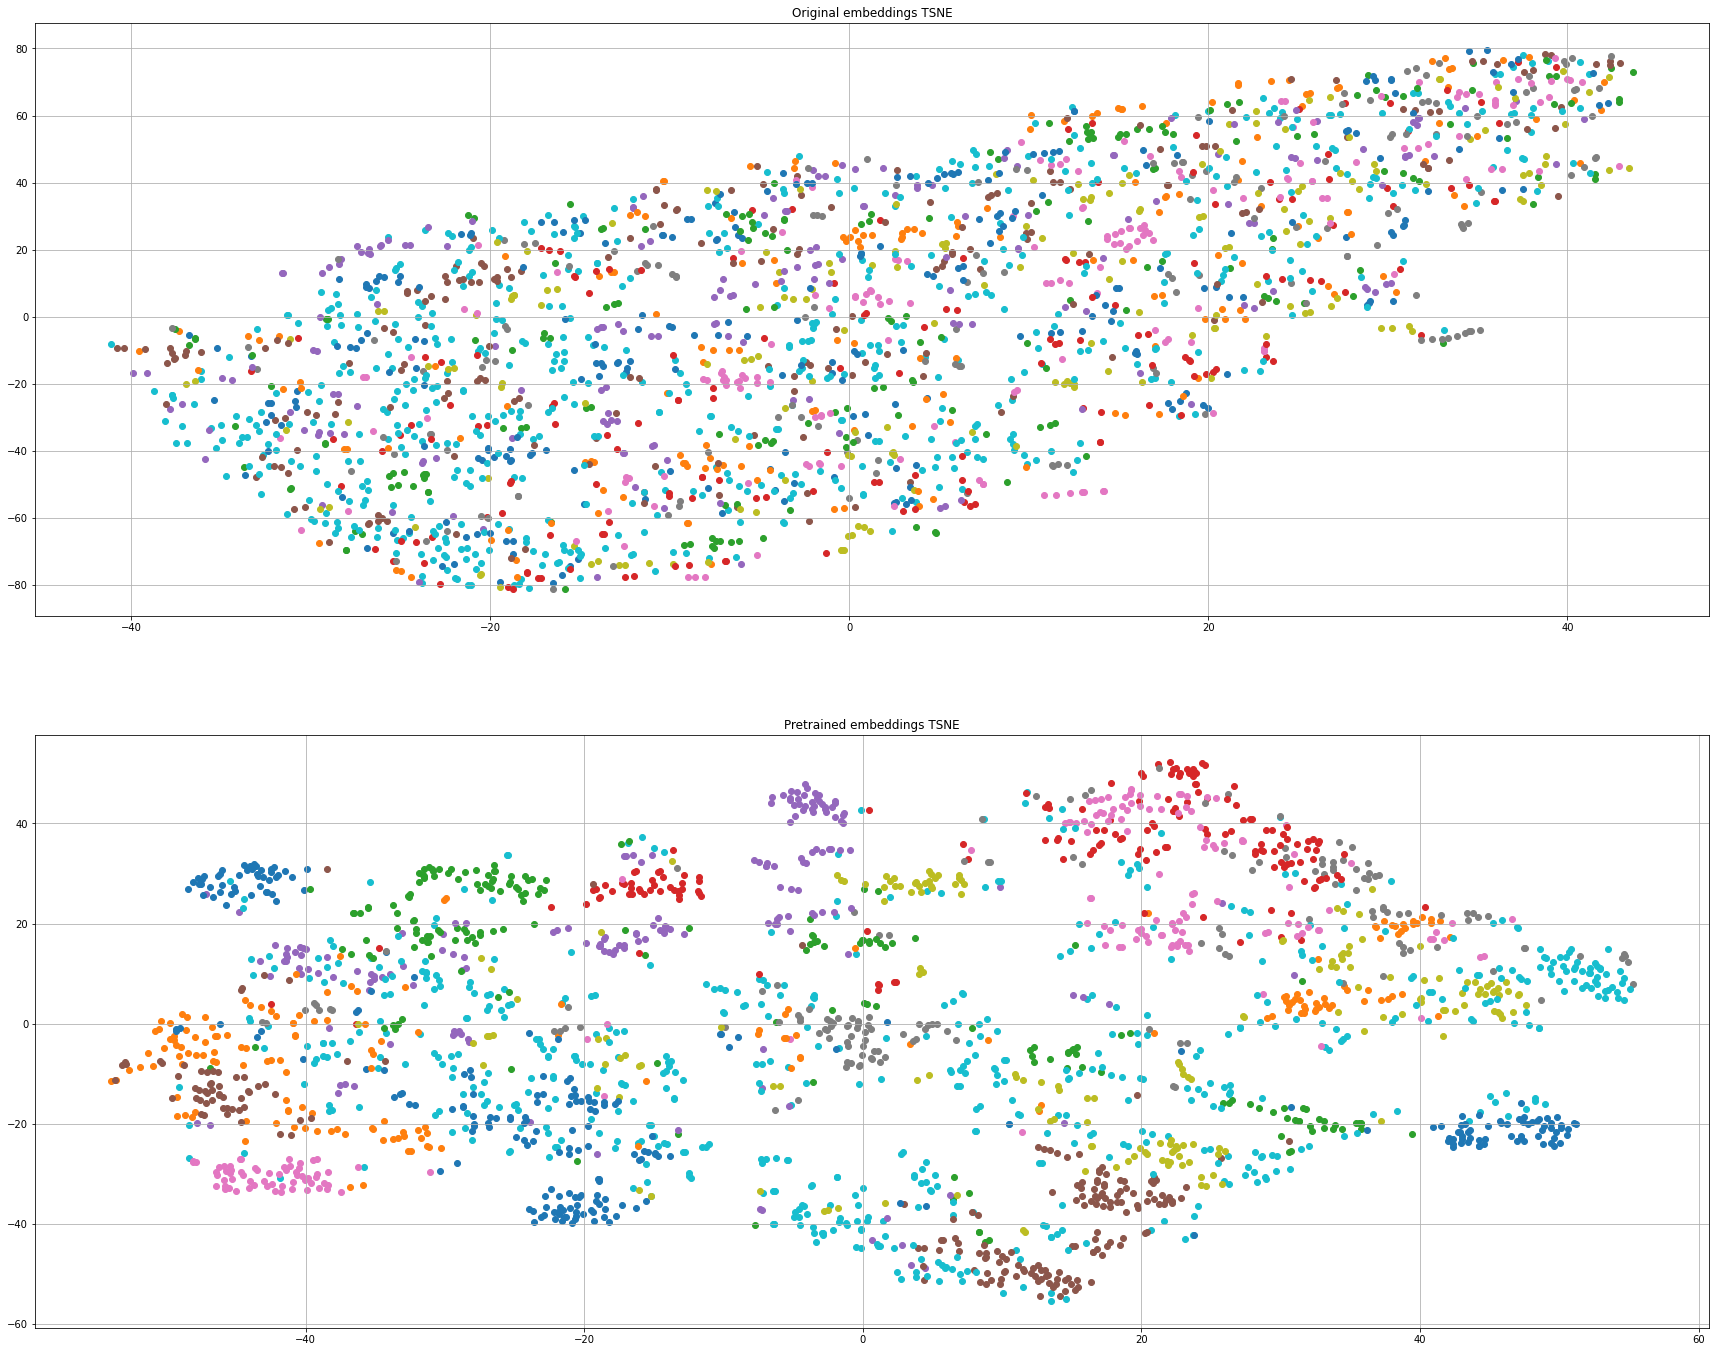

CPU times: user 1min 18s, sys: 169 ms, total: 1min 18s
Wall time: 29.5 s


In [ ]:
%%time
from sklearn.manifold import TSNE
plt.figure(figsize=(30,24))

tsne = TSNE()
train_classes_indexes = get_indexes_of_samples(unseen_test_df['targets'].tolist())

tsne_original_bert_val_emb = tsne.fit_transform(unseen_test_embeddings.cpu())
tsne_pretrained_bert_val_emb = tsne.fit_transform(new_unseen_test_embeddings.cpu())


plt.subplot(2, 1, 1), plt.title('Original embeddings TSNE'), plt.grid()
for key, val in train_classes_indexes.items():
    plt.scatter(x=tsne_original_bert_val_emb[val,0],y=tsne_original_bert_val_emb[val,1],label=key)

plt.subplot(2, 1, 2), plt.title('Pretrained embeddings TSNE'), plt.grid()
for key, val in train_classes_indexes.items():
    plt.scatter(x=tsne_pretrained_bert_val_emb[val,0],y=tsne_pretrained_bert_val_emb[val,1],label=key)

plt.show()